## Important libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt


In [23]:
#!pip install nelson_siegel_svensson

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for nelson_siegel_svensson from https://files.pythonhosted.org/packages/20/8e/775d07576b015e79d7aae476cda14e98c1c562b4d4b4e20ff6a93b106e4e/nelson_siegel_svensson-0.5.0-py2.py3-none-any.whl.metadata


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

## Calculating the price of a classic european option in the Heston model:
We use these prices to further esimate the parameters of this model

In [3]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

In [4]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [5]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [13]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\ASUS


In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/14/03/3c854ca3e02eedf614abba4b2e177c469bf3af58207fa30d5098c5d652fe/yfinance-0.2.37-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6 kB ? eta -:--:--
     --- ------------------------------------ 30.7/314.6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Extracting a dataset from yfinance:

In [6]:
import yfinance as yf
aapl = yf.Ticker("AAPL")

In [ ]:
opt = aapl.option_chain('2024-05-17')

In [78]:
hist=aapl.history()
hist.reset_index(inplace=True)

hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-02-15 00:00:00-05:00,183.550003,184.490005,181.350006,183.860001,65434500,0.0,0.0
1,2024-02-16 00:00:00-05:00,183.419998,184.850006,181.669998,182.309998,49701400,0.0,0.0
2,2024-02-20 00:00:00-05:00,181.789993,182.429993,180.000000,181.559998,53665600,0.0,0.0
3,2024-02-21 00:00:00-05:00,181.940002,182.889999,180.660004,182.320007,41529700,0.0,0.0
4,2024-02-22 00:00:00-05:00,183.479996,184.960007,182.460007,184.369995,52292200,0.0,0.0
5,2024-02-23 00:00:00-05:00,185.009995,185.039993,182.229996,182.520004,45119700,0.0,0.0
6,2024-02-26 00:00:00-05:00,182.240005,182.759995,180.649994,181.160004,40867400,0.0,0.0
7,2024-02-27 00:00:00-05:00,181.100006,183.919998,179.559998,182.630005,54318900,0.0,0.0
8,2024-02-28 00:00:00-05:00,182.509995,183.119995,180.130005,181.419998,48953900,0.0,0.0
9,2024-02-29 00:00:00-05:00,181.270004,182.570007,179.529999,180.750000,136682600,0.0,0.0


In [9]:
current_price = aapl.history(period='1d')['Close'][0]
print(current_price)

171.60499572753906


In [10]:
print("Column Names:", hist.columns)


Column Names: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


### Data treatmant:

In [79]:
calls=opt.calls
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240517C00005000,2024-02-23 18:37:51+00:00,5.0,178.00,165.75,166.70,0.000000,0.000000,1,2,4.574223,True,REGULAR,USD
1,AAPL240517C00025000,2024-02-16 19:33:19+00:00,25.0,158.39,145.95,146.90,0.000000,0.000000,2,1,2.441410,True,REGULAR,USD
2,AAPL240517C00050000,2024-03-04 18:29:21+00:00,50.0,124.44,121.15,122.10,0.000000,0.000000,1,6,1.644045,True,REGULAR,USD
3,AAPL240517C00055000,2024-03-04 14:52:25+00:00,55.0,120.96,116.25,117.05,0.000000,0.000000,1,4,1.531741,True,REGULAR,USD
4,AAPL240517C00070000,2024-02-26 14:34:09+00:00,70.0,113.13,101.35,102.50,0.000000,0.000000,1,6,1.294437,True,REGULAR,USD
5,AAPL240517C00080000,2024-03-05 14:45:00+00:00,80.0,91.50,91.70,92.25,0.000000,0.000000,1,5,1.130131,True,REGULAR,USD
6,AAPL240517C00085000,2024-02-16 14:30:44+00:00,85.0,99.60,86.45,87.25,0.000000,0.000000,2,2,1.027837,True,REGULAR,USD
7,AAPL240517C00090000,2024-03-07 16:49:45+00:00,90.0,80.05,81.45,82.20,0.000000,0.000000,1,4,0.949708,True,REGULAR,USD
8,AAPL240517C00095000,2024-01-24 16:52:31+00:00,95.0,102.08,88.05,89.50,0.000000,0.000000,2,1,1.903931,True,REGULAR,USD
9,AAPL240517C00100000,2024-03-11 13:42:29+00:00,100.0,74.86,71.85,72.35,0.000000,0.000000,1,56,0.855714,True,REGULAR,USD


In [80]:
hist['Date'] = pd.to_datetime(hist['Date']).dt.date
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date

In [81]:
apple = pd.merge(hist,calls , left_on='Date', right_on='lastTradeDate')
apple = apple.drop(columns=['High' , 'Low','Close', 'Volume', 'Dividends','Stock Splits' , 'bid', 'ask','change','percentChange', 'volume','openInterest', 'impliedVolatility', 'inTheMoney' ,'contractSize','currency' ])

In [6]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([0.15,0.27,0.50,0.93,1.52,2.13,2.32,2.34,2.37,2.32,2.65,2.52]).astype(float)/100
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds)

In [84]:
Maturity=dt(2024,5,17)
apple['Date'] = pd.to_datetime(apple['Date'])
apple['tau']=apple['Date'].apply(lambda x: Maturity - x )
apple['tau']=pd.to_numeric(apple['tau'].astype(str).str.replace('days',''),errors='coerce')
apple['tau']=apple['tau'].apply(lambda x : (x+1)/365 )
apple['r']=apple['tau'].apply(curve_fit)
apple

,Date,Open,contractSymbol,lastTradeDate,strike,lastPrice,tau,r
0,2024-02-16,183.419998,AAPL240517C00025000,2024-02-16,25.0,158.39,0.252055,0.004906
1,2024-02-16,183.419998,AAPL240517C00085000,2024-02-16,85.0,99.60,0.252055,0.004906
2,2024-02-23,185.009995,AAPL240517C00005000,2024-02-23,5.0,178.00,0.232877,0.004515
3,2024-02-26,182.240005,AAPL240517C00070000,2024-02-26,70.0,113.13,0.224658,0.004346
4,2024-03-01,179.550003,AAPL240517C00280000,2024-03-01,280.0,0.03,0.213699,0.004118
5,2024-03-04,176.149994,AAPL240517C00050000,2024-03-04,50.0,124.44,0.205479,0.003945
6,2024-03-04,176.149994,AAPL240517C00055000,2024-03-04,55.0,120.96,0.205479,0.003945
7,2024-03-05,170.759995,AAPL240517C00080000,2024-03-05,80.0,91.50,0.202740,0.003887
8,2024-03-07,169.149994,AAPL240517C00090000,2024-03-07,90.0,80.05,0.197260,0.003770
9,2024-03-08,169.000000,AAPL240517C00115000,2024-03-08,115.0,59.40,0.194521,0.003712


## Optimisation process:
By optimizing the mean squared error, we estimate the Heston parameters:

In [85]:
# Extraction des éléments de minimisations:
K= apple['strike'].to_numpy('float')
Price = apple['lastPrice'].to_numpy('float')
tau= apple['tau'].to_numpy('float')
S0= apple['Open']
r=apple['r'].to_numpy('float')
# Initialisation des variables a estimer
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.1]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          "lambd": {"x0": 0.03, "lbub": [-1,1]},
          }
x0 = [param["x0"] for key, param in params.items()]

bnds = [param["lbub"] for key, param in params.items()]
# Fonction de minimisation
def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    err = np.sum((Price-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(Price))

    return err 

In [87]:
result = minimize(SqErr, x0, tol = 1e-2, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)

In [88]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9529331042482284
       x: [ 9.243e-02  3.002e+00  9.809e-02  1.000e+00 -9.232e-01
            6.523e-02]
     nit: 5
     jac: [ 8.841e-02  4.029e-03  6.217e-03 -1.313e-01 -1.205e-01
            3.824e-03]
    nfev: 38
    njev: 5

In [8]:
x=[9.243e-02 , 3.002e+00 , 9.809e-02 , 1.000e+00 ,-9.232e-01, 6.523e-02]

In [9]:
v0, kappa, theta, sigma, rho, lambd = [param for param in x]
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
apple['heston_prices']=heston_prices

NameError: name 'S0' is not defined

In [100]:
err= SqErr(result.x)

In [101]:
print(err)

0.9529331042482284


## Pricing the asian options in the Heston model:

### MonteCarlo simulation for the asset price:

In [11]:
def MCHeston(St, K, r, T, 
              v0, kappa, theta, sigma, rho, 
              iterations, timeStepsPerYear):
    timesteps = int(T * timeStepsPerYear)
    dt = 1/timeStepsPerYear
    
    S_t = np.zeros((timesteps, iterations))
    V_t = np.zeros((timesteps, iterations))
    
    V_t[0,:] = v0
    S_t[0, :] = St
    
    means = [0,0]
    stdevs = [1/3, 1/3]
    covs = [[stdevs[0]**2          , stdevs[0]*stdevs[1]*rho], 
            [stdevs[0]*stdevs[1]*rho,           stdevs[1]**2]]
    Z = np.random.multivariate_normal(means, covs, (iterations, timesteps)).T
    Z1 = Z[0]
    Z2 = Z[1]
    for i in range(1, timesteps):
        V_t[i,:] = np.maximum(V_t[i-1,:] + 
                kappa * (theta - V_t[i-1,:])* dt + 
                sigma *  np.sqrt(V_t[i-1,:] * dt) * Z2[i,:],0)
        S_t[i,:] = S_t[i-1,:] + r * S_t[i,:] * dt + np.sqrt(V_t[i,:] * dt) * S_t[i-1,:] * Z1[i,:]
    return (S_t,V_t)

In [12]:
S_p,V_p=MCHeston(183,25,0.0049,0.252,v0,kappa,theta,sigma,rho,1000,int(365*0.252))

In [45]:
print(S_p)

[[183.         183.         183.         ... 183.         183.
  183.        ]
 [180.77265661 183.55548845 179.71754993 ... 179.98039637 184.01156838
  184.61526178]
 [181.2548525  184.95800916 176.94041426 ... 179.57147559 183.33533252
  184.0140756 ]
 ...
 [183.26827779 176.18156506 164.18304584 ... 170.79583947 180.59439152
  189.27484581]
 [183.81087923 176.14562367 162.41491977 ... 169.6540865  182.29711517
  190.24055552]
 [184.26625838 178.10232978 164.44371167 ... 173.01102418 182.23905378
  188.02572806]]


In [3]:
T=0.252*365
N=int(365*0.252)
time = np.linspace(0,int(N*T),1000)

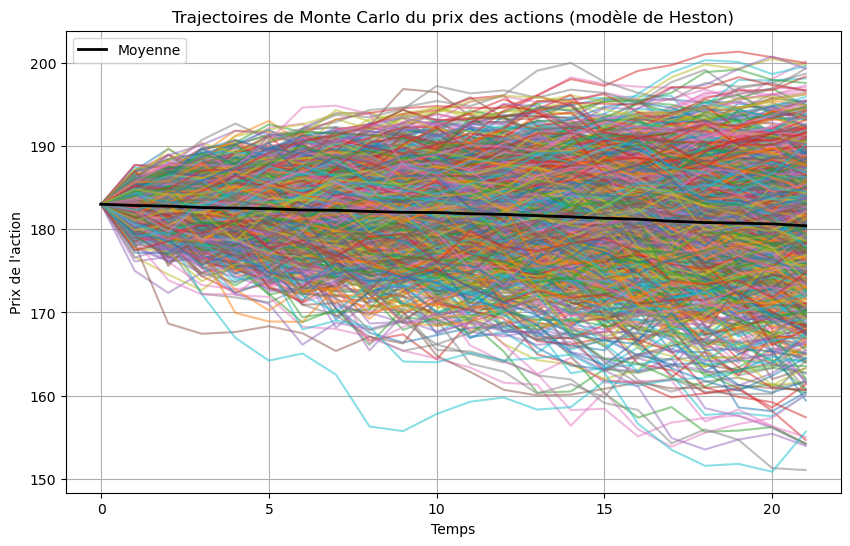

In [14]:
mean_S=np.mean(S_p, axis=1)
num_paths=100
plt.figure(figsize=(10, 6))
for i in range(1000):
    plt.plot(S_p[:, i], alpha=0.5)
plt.plot(mean_S, color='black', linewidth=2, label='Moyenne')
plt.xlabel('Temps')
plt.ylabel("Prix de l'action")
plt.title('Trajectoires de Monte Carlo du prix des actions (modèle de Heston)')
plt.legend()
plt.grid(True)
plt.show()

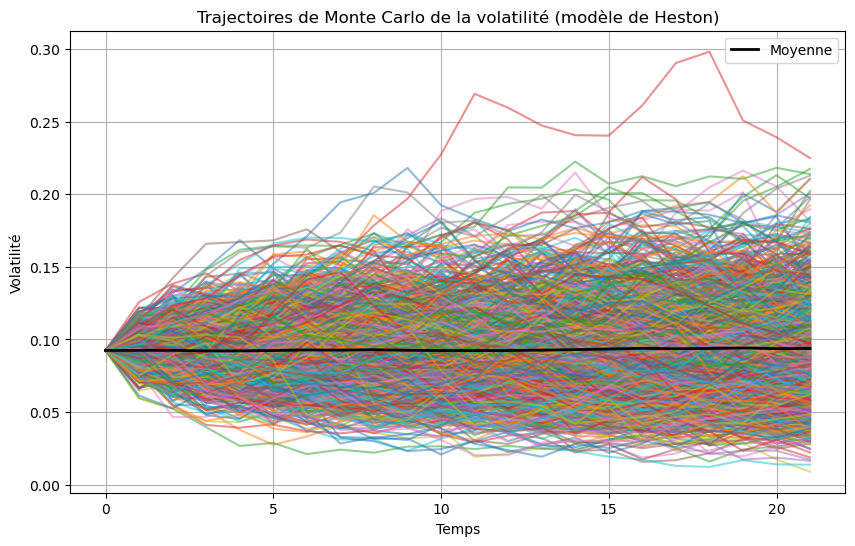

In [16]:
mean_V=np.mean(V_p, axis=1)
num_paths=100
plt.figure(figsize=(10, 6))
for i in range(1000):
    plt.plot(V_p[:, i], alpha=0.5)
plt.plot(mean_V, color='black', linewidth=2, label='Moyenne')
plt.xlabel('Temps')
plt.ylabel("Volatilité")
plt.title('Trajectoires de Monte Carlo de la volatilité (modèle de Heston)')
plt.legend()
plt.grid(True)
plt.show()

In [388]:
S1=MCHeston(183, K, 0.0049, 0.252, v0, kappa, theta, sigma, rho, 1000, int(0.252*365))
S1

array([3706.85681761, 3994.8772753 , 4112.46423687, 4092.88374368,
       4102.43271159, 4054.28248698, 3965.82117648, 3888.4896858 ,
       3911.17147769, 3850.5590796 , 3764.96836242, 4099.61542892,
       3868.68674751, 4065.41749037, 4126.32073072, 3848.82343357,
       4170.84966313, 4072.86375989, 3978.74257651, 4127.74324948,
       3881.90442731, 3893.78633057, 3964.59909382, 3847.41238117,
       4029.5191173 , 4066.86441077, 4067.18340843, 3956.99968496,
       3916.5027963 , 3888.57034237, 4082.51811939, 4290.02128576,
       3977.87722611, 4126.19659328, 3963.7993124 , 4128.20667009,
       3909.52751438, 4065.65795484, 4177.08707788, 4066.74701933,
       3933.86323008, 3979.10752545, 4065.34387988, 3946.07103144,
       3835.9709512 , 4158.06560959, 3999.60488666, 4131.83556913,
       3992.97997845, 3920.24209562, 4049.3966109 , 4058.00245696,
       3715.3098571 , 3935.83025523, 3954.0535899 , 4001.75326743,
       4021.40373774, 3560.38384193, 3920.54718841, 4130.13666

### Option pricing:

In [73]:
import math as m
def MCHeston_option(St, K, r, T, 
              v0, kappa, theta, sigma, rho, 
              iterations, timeStepsPerYear):
    timesteps = int(T * timeStepsPerYear)
    dt = 1/timeStepsPerYear
    S_t = np.zeros((timesteps, iterations))
    V_t = np.zeros((timesteps, iterations))
    V_t[0,:] = v0
    S_t[0, :] = St
    means = [0,0]
    stdevs = [1/3, 1/3]
    covs = [[stdevs[0]**2          , stdevs[0]*stdevs[1]*rho], 
            [stdevs[0]*stdevs[1]*rho,           stdevs[1]**2]]
    Z = np.random.multivariate_normal(means, covs, (iterations, timesteps)).T
    Z1 = Z[0]
    Z2 = Z[1]
    for i in range(1, timesteps):
        V_t[i,:] = np.maximum(V_t[i-1,:] + 
                kappa * (theta - V_t[i-1,:])* dt + 
                sigma *  np.sqrt(V_t[i-1,:] * dt) * Z2[i,:],0)
        
        S_t[i,:] = S_t[i-1,:] + r * S_t[i,:] * dt + np.sqrt(V_t[i,:] * dt) * S_t[i-1,:] * Z1[i,:]
    Y=np.sum(S_t,axis=0)/timesteps
    v=np.maximum(Y-K,0)*m.exp(-r*T)
    Y=np.maximum(Y-K,0)*m.exp(-r*T)/iterations
    return (v,np.sum(Y))

In [74]:
S_t,S2=MCHeston_option(183, 25, 0.0049, 0.252, v0, kappa, theta, sigma, rho, 1000, int(0.252*365))

In [76]:
print(S2)

156.65177362413723


In [40]:
k_vals=[i*25 for i in range(15)]
option_prices1=[MCHeston_option(183, k, 0.0049, 0.252, v0, kappa, theta, sigma, rho, 1000, int(0.252*365))[1] for k in k_vals]

In [41]:
print(option_prices1)

[181.79718654977273, 156.63033345102616, 131.93789267332187, 106.77595035341491, 81.88567370823898, 56.87178331569061, 32.13837219072778, 7.139446884896567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
prices

[181.8467174656903,
 156.72138841174646,
 131.79295856675657,
 106.70007193388646,
 81.80965385903622,
 56.645022194604735,
 31.675944162502347,
 7.118260554095563,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [77]:
# Confidence Interval:
from scipy.stats import norm
def IC(v,alpha):
    M=len(v)
    s=np.mean(v)
    std=np.std(v)
    quantile1 = norm.ppf(alpha/2, loc=0, scale=1)
    quantile2 = norm.ppf(1-alpha/2, loc=0, scale=1)
    inf= s+(quantile1*std)/(M**0.5)
    sup= s+(quantile2*std)/(M**0.5)
    return([inf,sup],s)

In [78]:
print(IC(S_t,0.05))

([156.32757131870588, 156.9759759295686], 156.65177362413723)


In [80]:
print(confidence_intervals)

[[181.62656106646378, 182.2287532716721], [156.31380734105454, 156.91143482769513], [131.3659356824445, 131.9983480804866], [106.47309103959961, 107.10587788004929], [81.53985080492967, 82.16541282810977], [56.68603112416226, 57.282252635792254], [31.57684720841754, 32.198468968523834], [6.8688448157907285, 7.417836855435754], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


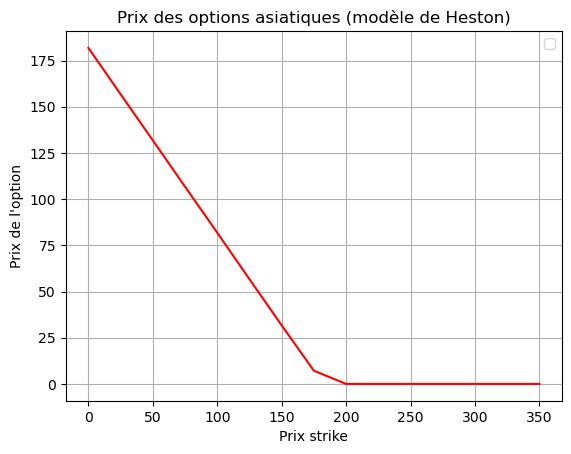

In [61]:
plt.plot(k_vals,prices, color='red', alpha=1)
plt.xlabel('Prix strike')
plt.ylabel("Prix de l'option")
plt.title('Prix des options asiatiques (modèle de Heston)')
plt.legend()
plt.grid(True)
plt.show()

## Comparing the results with the Black-Scholes model:

In [415]:
# Générer St(k+1)/Stk
def Genere_Stk(pas,sigma,r): 
    W=random.gauss(0,pas**0.5)
    return(m.exp(sigma*W-0.5*(sigma*sigma)*pas+r*pas))
def Approx1(M,N,T,K,r,sigma,S0):
    S=0
    h=T/N
    v=[] # Stocker chaque itération dans v
    for i in range(M):
        S1=S0
        Y=S1
        for j in range(1,N):
            x=Genere_Stk(h,sigma,r)*S1
            Y+=x
            S1=x
        Y=(h/T)*Y
        v.append(m.exp(-r*T)*max(Y-K,0))
        S += max(Y-K,0)
    S=m.exp(-r*T)/M*S
    return(S,v)

In [421]:
import random 
Open=apple['Open'].to_numpy('float')
BS_prices=[]
for i in range(len(K)):
    BS_prices.append(Approx1(1000,int(tau[i]*365),tau[i],K[i],r[i],v0,Open[i])[0])
apple['BS_asian_price']=pd.DataFrame(BS_prices)
apple

,Date,Open,contractSymbol,lastTradeDate,strike,lastPrice,tau,r,heston_prices,heston_asian_price,BS_asian_price
0,2024-02-16,183.419998,AAPL240517C00025000,2024-02-16,25.0,158.39,0.252055,0.004906,157.646433,157.435438,158.256363
1,2024-02-16,183.419998,AAPL240517C00085000,2024-02-16,85.0,99.60,0.252055,0.004906,98.475542,97.090697,98.560706
2,2024-02-23,185.009995,AAPL240517C00005000,2024-02-23,5.0,178.00,0.232877,0.004515,178.127680,178.767378,180.125802
3,2024-02-26,182.240005,AAPL240517C00070000,2024-02-26,70.0,113.13,0.224658,0.004346,112.104327,111.168522,112.087640
4,2024-03-01,179.550003,AAPL240517C00280000,2024-03-01,280.0,0.03,0.213699,0.004118,-0.192563,0.000000,0.000000
5,2024-03-04,176.149994,AAPL240517C00050000,2024-03-04,50.0,124.44,0.205479,0.003945,125.798477,125.110771,126.084278
6,2024-03-04,176.149994,AAPL240517C00055000,2024-03-04,55.0,120.96,0.205479,0.003945,120.859652,120.303426,120.982018
7,2024-03-05,170.759995,AAPL240517C00080000,2024-03-05,80.0,91.50,0.202740,0.003887,90.708038,89.833814,90.640258
8,2024-03-07,169.149994,AAPL240517C00090000,2024-03-07,90.0,80.05,0.197260,0.003770,79.170887,78.286391,79.180985
9,2024-03-08,169.000000,AAPL240517C00115000,2024-03-08,115.0,59.40,0.194521,0.003712,54.371063,53.216208,53.789442


In [414]:
asian_prices=[]
for i in range(len(K)):
    asian_prices.append(MCHeston_option(Open[i],K[i],r[i],tau[i],v0,kappa,theta,sigma,rho,1000,int(tau[i]*365)))
apple['heston_asian_price']=pd.DataFrame(asian_prices)
apple

,Date,Open,contractSymbol,lastTradeDate,strike,lastPrice,tau,r,heston_prices,heston_asian_price
0,2024-02-16,183.419998,AAPL240517C00025000,2024-02-16,25.0,158.39,0.252055,0.004906,157.646433,157.435438
1,2024-02-16,183.419998,AAPL240517C00085000,2024-02-16,85.0,99.60,0.252055,0.004906,98.475542,97.090697
2,2024-02-23,185.009995,AAPL240517C00005000,2024-02-23,5.0,178.00,0.232877,0.004515,178.127680,178.767378
3,2024-02-26,182.240005,AAPL240517C00070000,2024-02-26,70.0,113.13,0.224658,0.004346,112.104327,111.168522
4,2024-03-01,179.550003,AAPL240517C00280000,2024-03-01,280.0,0.03,0.213699,0.004118,-0.192563,0.000000
5,2024-03-04,176.149994,AAPL240517C00050000,2024-03-04,50.0,124.44,0.205479,0.003945,125.798477,125.110771
6,2024-03-04,176.149994,AAPL240517C00055000,2024-03-04,55.0,120.96,0.205479,0.003945,120.859652,120.303426
7,2024-03-05,170.759995,AAPL240517C00080000,2024-03-05,80.0,91.50,0.202740,0.003887,90.708038,89.833814
8,2024-03-07,169.149994,AAPL240517C00090000,2024-03-07,90.0,80.05,0.197260,0.003770,79.170887,78.286391
9,2024-03-08,169.000000,AAPL240517C00115000,2024-03-08,115.0,59.40,0.194521,0.003712,54.371063,53.216208
